# Setup

In [107]:
%%capture
%pip install kmodes

In [108]:
import pandas as pd
import numpy as np

# Data vizualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express  as px
import plotly.graph_objects as go

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer


# machine learning
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.cluster import k_means, dbscan, mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, PowerTransformer

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kmodes.kmodes import KModes            # clustering categorical data
from kmodes.kprototypes import KPrototypes  # clustering mixed data

# Didatic purposes
import string
from ipywidgets import interact

In [109]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

# Data Understanding

In [110]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DNC Desafios/data.csv', encoding='latin1')

In [111]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [113]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Perguntas de negocio

In [114]:
# Quantidade de produtos e
df[['Description','Country']].nunique()

Description    4223
Country          38
dtype: int64

<Axes: >

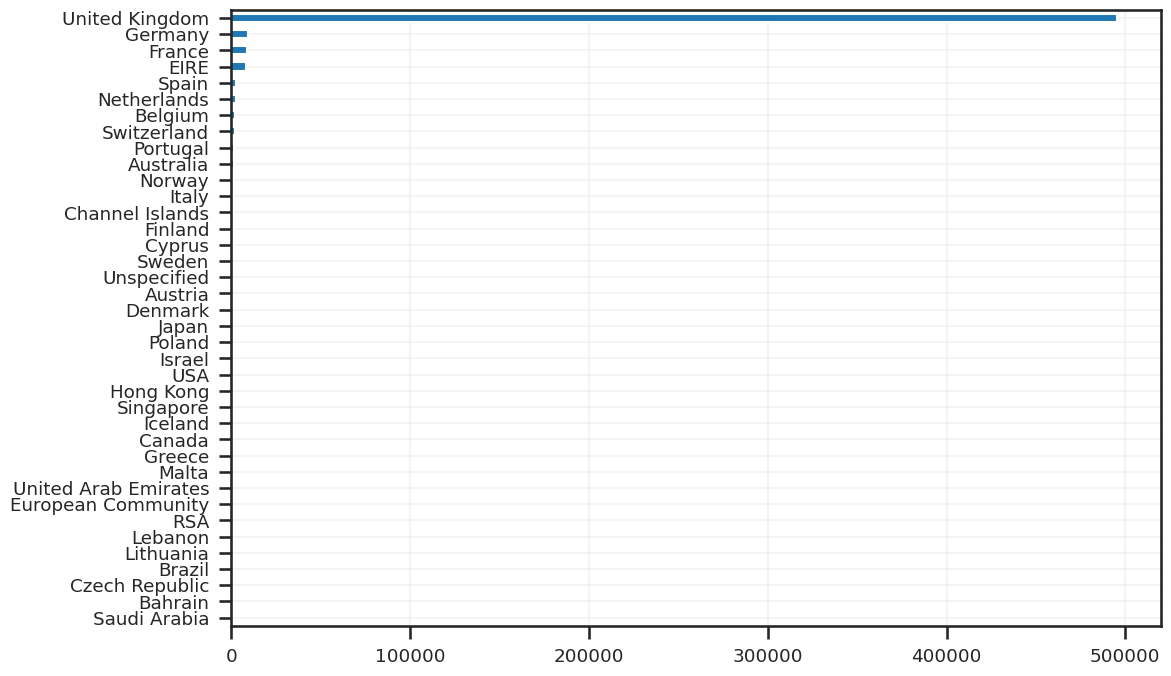

In [115]:
# Plotando os paises que tem mais vendas
df['Country'].value_counts(ascending=True).plot.barh()

# Vemos que a grande maioria das vendas foi feita no reino unido

In [116]:
# Verificando os 10 produtos mais vendidos
df['Description'].value_counts().sort_values(ascending=False).reset_index().head(10)

,index,Description
0,WHITE HANGING HEART T-LIGHT HOLDER,2369
1,REGENCY CAKESTAND 3 TIER,2200
2,JUMBO BAG RED RETROSPOT,2159
3,PARTY BUNTING,1727
4,LUNCH BAG RED RETROSPOT,1638
5,ASSORTED COLOUR BIRD ORNAMENT,1501
6,SET OF 3 CAKE TINS PANTRY DESIGN,1473
7,PACK OF 72 RETROSPOT CAKE CASES,1385
8,LUNCH BAG BLACK SKULL.,1350
9,NATURAL SLATE HEART CHALKBOARD,1280


In [117]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [118]:
df.duplicated().sum()

5268

### Pontos visto no understanding:

- Arrumar o formato da data
- CustomerID para int
- Reomver os nulos
- Remover os outliers das colunas Quantity e UnitPrice
- Remover os duplicados

# Data Cleaning

In [119]:
# Removendo os nulos
df.dropna(inplace=True)


In [120]:
# Removendo os dados duplicados
df.drop_duplicates(inplace=True)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


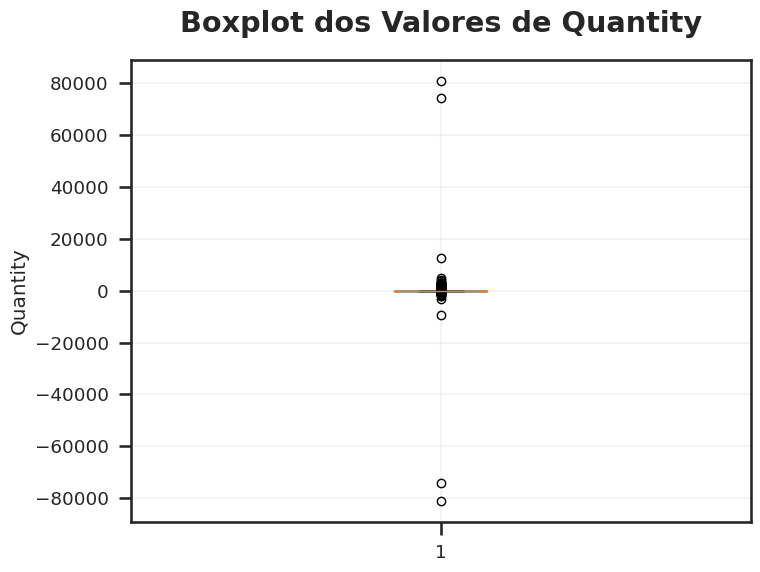

In [122]:
# Verificando os outliers e removendo
plt.figure(figsize=(8, 6))
plt.boxplot(df['Quantity'])
plt.title('Boxplot dos Valores de Quantity')
plt.ylabel('Quantity')
plt.show()

# Temos dados muito fora do padrão para as duas colunas

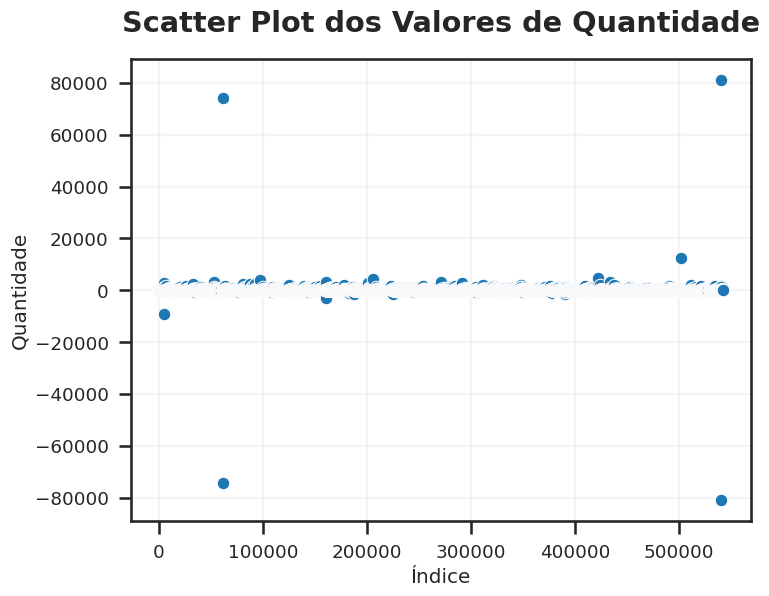

In [123]:
# Plotando um scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x=df.index, y='Quantity')
plt.title('Scatter Plot dos Valores de Quantidade')
plt.ylabel('Quantidade')
plt.xlabel('Índice')
plt.show()

In [124]:
# Removendo os outliers
df = df.query('Quantity<= 20000  and Quantity>=0')

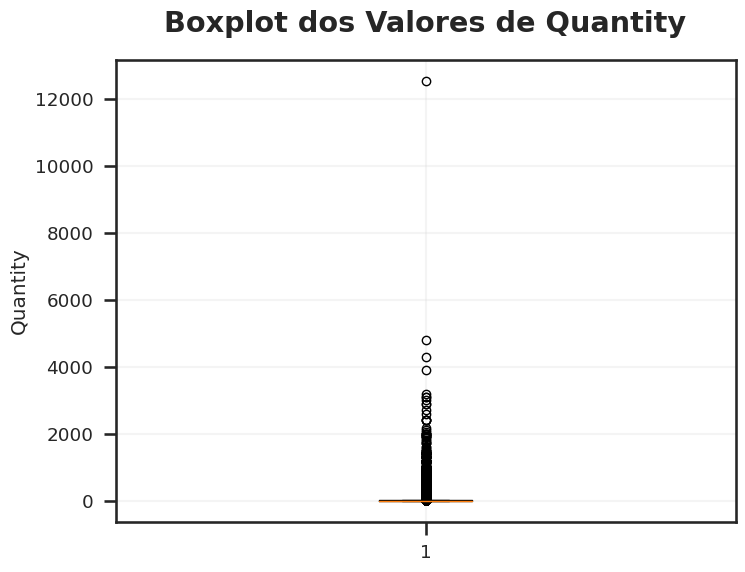

In [125]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['Quantity'])
plt.title('Boxplot dos Valores de Quantity')
plt.ylabel('Quantity')
plt.show()

# Ainda temos um valor bem outliers, vamos remover

In [126]:
df = df.query('Quantity<= 10000')

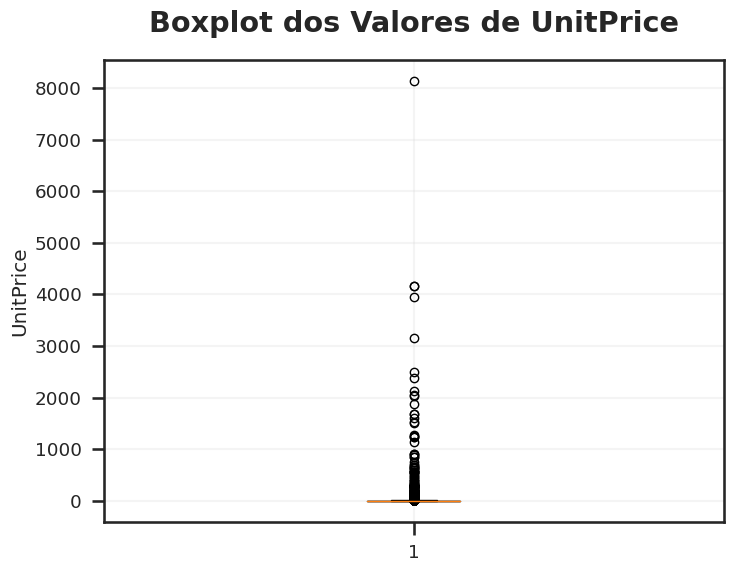

In [127]:
# Verificando Unitprice
plt.figure(figsize=(8, 6))
plt.boxplot(df['UnitPrice'])
plt.title('Boxplot dos Valores de UnitPrice')
plt.ylabel('UnitPrice')
plt.show()

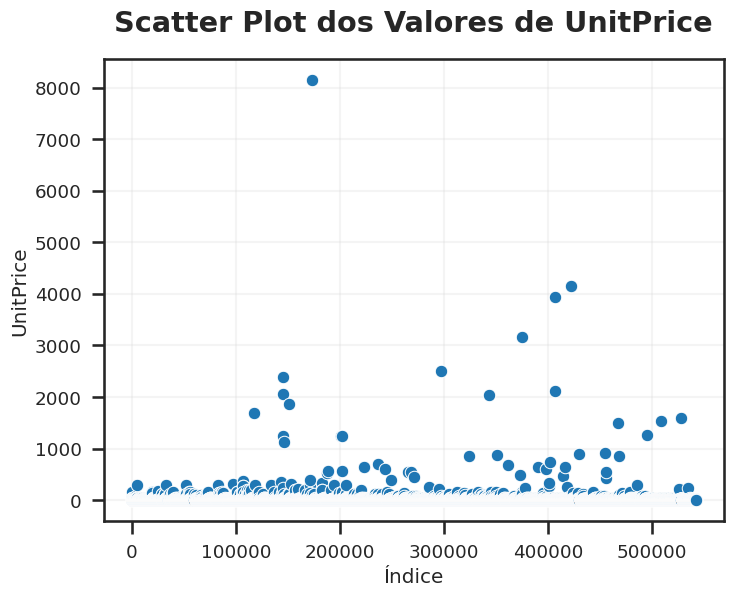

In [128]:
# Plotando um scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x=df.index, y='UnitPrice')
plt.title('Scatter Plot dos Valores de UnitPrice')
plt.ylabel('UnitPrice')
plt.xlabel('Índice')
plt.show()

In [129]:
# Removendo os outliers
df = df.query('UnitPrice<= 5000  and Quantity>=0')

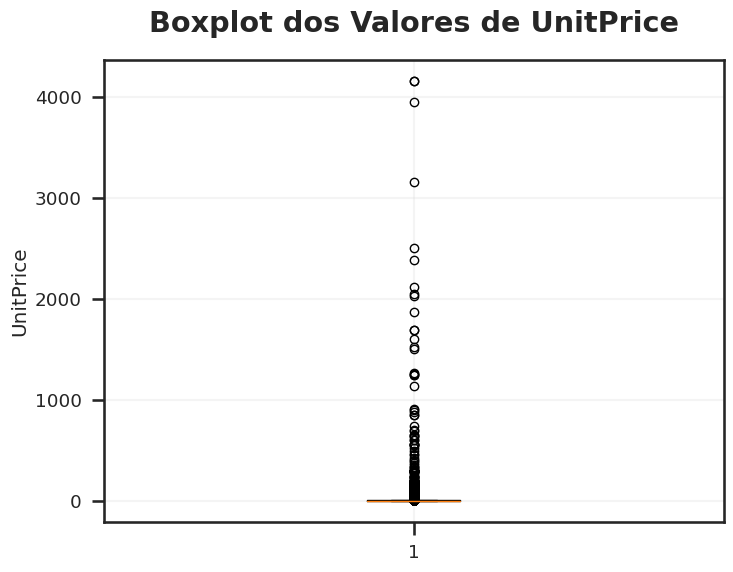

In [130]:
# Verificando Unitprice
plt.figure(figsize=(8, 6))
plt.boxplot(df['UnitPrice'])
plt.title('Boxplot dos Valores de UnitPrice')
plt.ylabel('UnitPrice')
plt.show()

# Data Preparation

In [131]:
# Convertendo para o formato de data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [132]:
# Coluna de CustomerID para int
df['CustomerID'] = df['CustomerID'].astype(int)

In [133]:
# Mostrando a data maxima e minima do problema
df.InvoiceDate.agg(['min','max'])

min   2010-12-01 08:26:00
max   2011-12-09 12:50:00
Name: InvoiceDate, dtype: datetime64[ns]

In [134]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [135]:
# Adicionando a coluna de total de compra
df['Total_Compra'] =  df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Compra
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## Normalizando os dados e separando os valores mais importantes

os valores que estão sendo colocados aqui são:

RFM:
- R (Recency): Tempo que o cliente realizou a última compra (em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do **ticket médio** gasto pelo cliente



In [136]:
# Criando um novo dataframe para ser usado com o cluster que atende algumas perguntas

df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('01-01-2012') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('Total_Compra', 'mean')
  )
)

df_rfm.head()

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824


<Axes: >

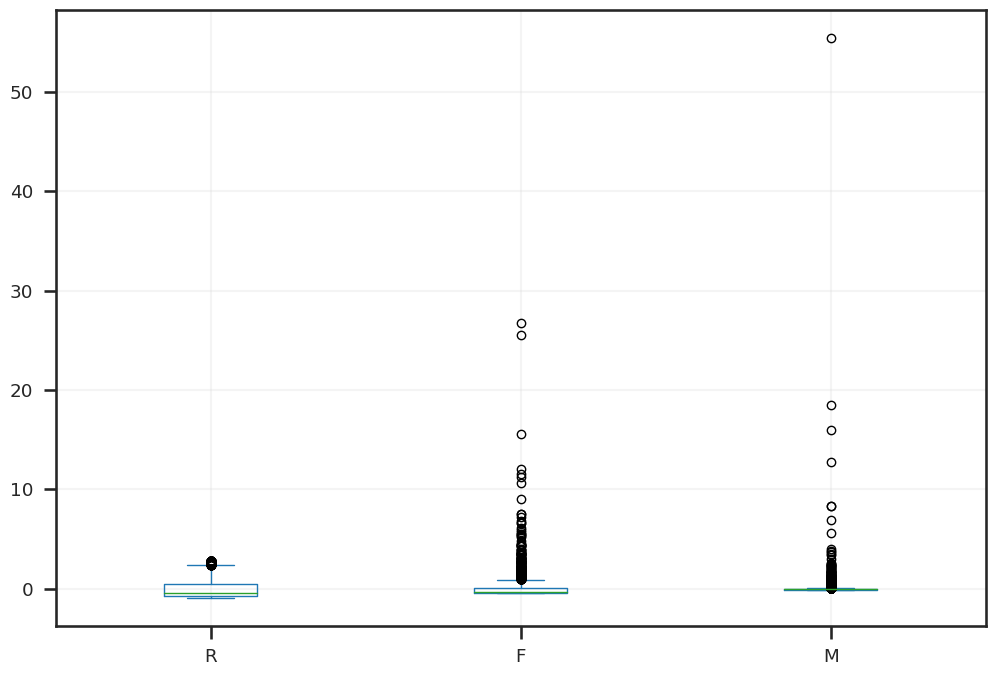

In [137]:
# Aplicando escala no dataframe
df_scaled =df_rfm.apply(scale)
df_scaled.plot.box()

Podemos ver que mesmo retirando outliers de estapas anteriores é importante remover este em questão para o modelo não perder precisão

In [140]:
# Encontrando esse valor que está com valor M muito alto
df_scaled[df_scaled['M']>50]

,R,F,M
CustomerID,,,
15098,0.899878,-0.16523,55.442267


In [141]:
# verificando o que temos com esse customer ID
df[df['CustomerID']==15098]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Compra
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


Podemos observr que esse cliente tem uma grande quantidade de item comprados e um preço muito elevado, como são poucos dados isso vai ser retirado

In [145]:
df_rfm = df_rfm.drop(15098)

<Axes: >

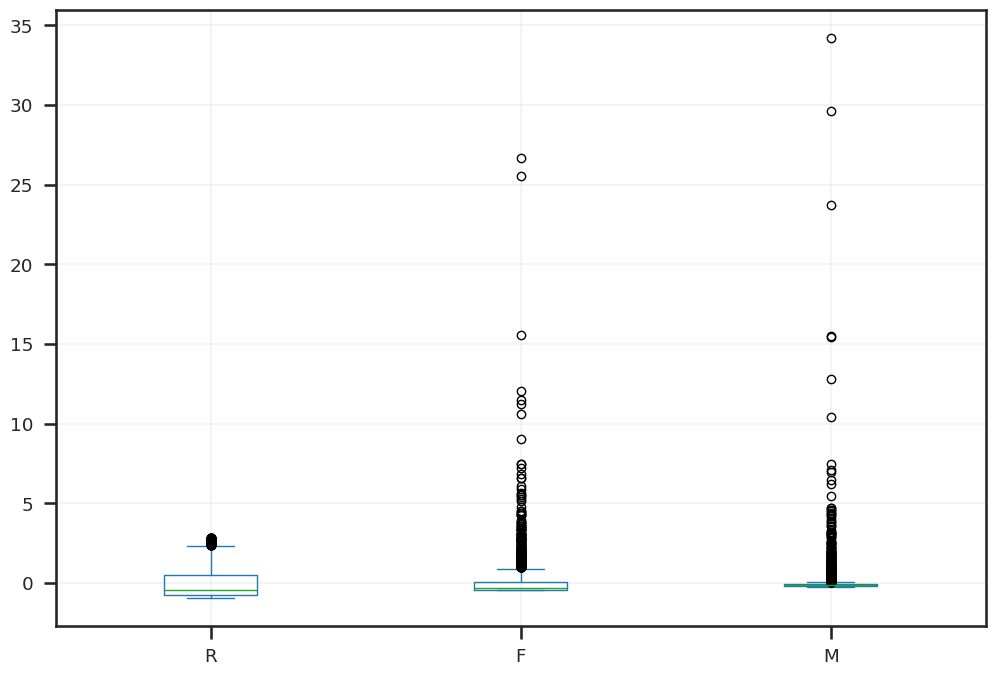

In [146]:
df_rfm.apply(scale).plot.box()

In [148]:
# Utilizando o Power Transform para acertar a escala dos dados
scaler = PowerTransformer()

# Modeling
